# US–CN Spillover Analysis
This notebook contains only the **useful code snippets** we built:
- data + lag creation
- VAR and Granger
- Diebold–Yilmaz style spillover (GFEVD)
- rolling correlation of GARCH-standardized residuals
- ML baselines (linear, XGBoost) with **time-series CV**
- extension for richer features (momentum, vol, corr)


In [1]:
import numpy as np
import pandas as pd

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

# optional ML
import xgboost as xgb

# optional GARCH
from arch import arch_model

pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

## 1. Load / prepare base data
We expect a DataFrame `data` with at least:
- `Date` (datetime)
- `US_Ret` (weekly return)
- `CN_Ret` (weekly return)

Sample rows:
        Date   US_Close   CN_Close  US_Ret  CN_Ret
0 2009-01-16 1,159.1000 1,628.8000 -0.0370  0.0232
1 2009-01-23 1,107.7400 1,647.8200 -0.0453  0.0116
2 2009-01-30 1,103.6600 1,647.8200 -0.0037  0.0000
3 2009-02-06 1,168.7900 1,795.7500  0.0573  0.0860
4 2009-02-13 1,122.4300 1,975.7000 -0.0405  0.0955


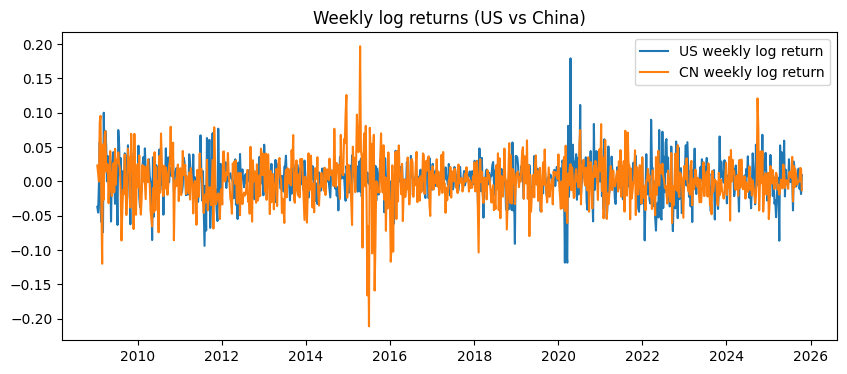

In [2]:
us = pd.read_csv('IXID_index.csv', parse_dates=['Date']).sort_values('Date')
cn = pd.read_csv('000034_index.csv', parse_dates=['Date']).sort_values('Date')

us_w = us.set_index('Date')['Close']   # keine Resample nötig
cn_w = cn.set_index('Date')['Close']

# Resample both series to weekly (Friday close). If your data is already weekly, this will simply keep it.
us_w = us.set_index('Date')['Close'].resample('W-FRI').last().ffill()
cn_w = cn.set_index('Date')['Close'].resample('W-FRI').last().ffill()


# Build DataFrame with log returns
data = pd.DataFrame({'US_Close': us_w, 'CN_Close': cn_w}).dropna()
# Log returns: simple and commonly used for VAR / GARCH
data['US_Ret'] = np.log(data['US_Close']).diff()
data['CN_Ret'] = np.log(data['CN_Close']).diff()
# drop the first NA after differencing
data = data.dropna().reset_index().rename(columns={'index': 'Date'})


print('Sample rows:')
print(data.head())


plt.figure(figsize=(10,4))
plt.plot(data['Date'], data['US_Ret'], label='US weekly log return')
plt.plot(data['Date'], data['CN_Ret'], label='CN weekly log return')
plt.legend()
plt.title('Weekly log returns (US vs China)')
plt.show()



In [3]:
assert "Date" in data.columns
assert "US_Ret" in data.columns
assert "CN_Ret" in data.columns

data = data.sort_values("Date").reset_index(drop=True)

## 2. Lag construction helper
Corrected version (the first one returned after lag 1).

In [4]:
def make_lags(df: pd.DataFrame, lags: int = 4) -> pd.DataFrame:
    """Create US/CN lag features per date.
    Expects columns: Date, US_Ret, CN_Ret
    """
    tmp = df.copy().set_index("Date")
    for i in range(1, lags + 1):
        tmp[f"CN_lag{i}"] = tmp["CN_Ret"].shift(i)
        tmp[f"US_lag{i}"] = tmp["US_Ret"].shift(i)
    tmp = tmp.dropna().reset_index()
    return tmp

lags = 4
ml_df = make_lags(data, lags=lags)
ml_df.head()

,Date,US_Close,CN_Close,US_Ret,CN_Ret,CN_lag1,US_lag1,CN_lag2,US_lag2,CN_lag3,US_lag3,CN_lag4,US_lag4
0,2009-02-13,"1,122.4300","1,975.7000",-0.0405,0.0955,0.0860,0.0573,0.0000,-0.0037,0.0116,-0.0453,0.0232,-0.0370
1,2009-02-20,"1,057.8900","1,919.0000",-0.0592,-0.0291,0.0955,-0.0405,0.0860,0.0573,0.0000,-0.0037,0.0116,-0.0453
2,2009-02-27,"1,021.3600","1,702.1400",-0.0351,-0.1199,-0.0291,-0.0592,0.0955,-0.0405,0.0860,0.0573,0.0000,-0.0037
3,2009-03-06,948.5100,"1,796.2700",-0.0740,0.0538,-0.1199,-0.0351,-0.0291,-0.0592,0.0955,-0.0405,0.0860,0.0573
4,2009-03-13,"1,048.2500","1,748.8900",0.1000,-0.0267,0.0538,-0.0740,-0.1199,-0.0351,-0.0291,-0.0592,0.0955,-0.0405


## 3. VAR(1) and Granger causality (US ↔ CN)
Order selection showed lag=1 was sufficient.

In [5]:
# prepare for VAR
var_data = data[["US_Ret", "CN_Ret"]].set_index(data["Date"])  # index for convenience

# VAR(1)
model = VAR(var_data)
res = model.fit(1)
print(res.summary())

# Granger: does CN -> US?
print("\nGranger test: CN → US (H0: no causality)")
grangercausalitytests(var_data[["US_Ret", "CN_Ret"]], maxlag=4, verbose=True)

# Granger: does US -> CN?
print("\nGranger test: US → CN (H0: no causality)")
grangercausalitytests(var_data[["CN_Ret", "US_Ret"]], maxlag=4, verbose=True)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 30, Oct, 2025
Time:                     12:52:50
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.9727
Nobs:                     874.000    HQIC:                  -13.9929
Log likelihood:           3646.08    FPE:                8.26995e-07
AIC:                     -14.0055    Det(Omega_mle):     8.21346e-07
--------------------------------------------------------------------
Results for equation US_Ret
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.002844         0.000946            3.007           0.003
L1.US_Ret        -0.049046         0.034674           -1.414           0.157
L1.CN_Ret         0.025872         0.028868            0.896           0.37

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


{np.int64(1): ({'ssr_ftest': (np.float64(2.0951176951094213),
    np.float64(0.1481301496881676),
    np.float64(871.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(2.102333944346308),
    np.float64(0.14707448794499467),
    np.int64(1)),
   'lrtest': (np.float64(2.099809497480237),
    np.float64(0.14731749227372218),
    np.int64(1)),
   'params_ftest': (np.float64(2.095117695109708),
    np.float64(0.14813014968812724),
    np.float64(871.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(1.797354013223371),
    np.float64(0.16635312283340942),
    np.float64(868.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(3.6154148699170574),
    np.float64(0.16402975495563712),
    np.int64(2)),
   'lrtest': (np.float64(3.607949092198396),
    np.float64(0.16464320405682759),
    np.int64(2)),
   'params_ftest': (np.float64(1.7973540132233221),
    np.float64(0.1663531228334175),
    np.float64(868.0),
    2.0)},
   array([[0., 0., 1., 0., 0.],
     

## 4. Diebold–Yilmaz-style GFEVD spillover (2 variables)
This matches the code you ran, but wrapped once.

In [6]:
def gfevd_spillover(res, h: int = 10, labels=("US", "CN")):
    """Compute generalized FEVD matrix and total spillover index for a fitted VAR.
    res ... statsmodels VARResults
    h  ... forecast horizon
    """
    Psi = np.asarray(res.ma_rep(maxn=h - 1))   # (h, k, k)
    Sigma = np.asarray(res.sigma_u)            # (k, k)
    k = Psi.shape[1]
    sigma_diag = np.diag(Sigma).astype(float)

    num = np.zeros((k, k), dtype=float)
    den = np.zeros(k, dtype=float)

    for s in range(h):
        Ps = Psi[s]               # (k, k)
        B = Ps @ Sigma            # (k, k)
        num += (B * B) / sigma_diag[np.newaxis, :]
        den += np.sum(B * Ps, axis=1)

    GFEVD = num / den.reshape(-1, 1)
    GFEVD = GFEVD / GFEVD.sum(axis=1, keepdims=True)

    off_diag = GFEVD.sum() - np.trace(GFEVD)
    total_spill = off_diag / k

    idx = [f"{l}_recipient" for l in labels[:k]]
    cols = [f"{l}_source" for l in labels[:k]]
    df = pd.DataFrame(GFEVD, index=idx, columns=cols)
    return total_spill, df

total_spill, spill_df = gfevd_spillover(res, h=10, labels=("US", "CN"))
print(f"Total spillover index (h=10): {total_spill:.4f}")
print("\nFEVD share matrix (rows=recipient, cols=source):")
print(spill_df.round(4))

Total spillover index (h=10): 0.0505

FEVD share matrix (rows=recipient, cols=source):
              US_source  CN_source
US_recipient     0.9508     0.0492
CN_recipient     0.0518     0.9482


## 5. Rolling correlation of GARCH-standardized residuals
This shows time-varying co-movement of shocks.

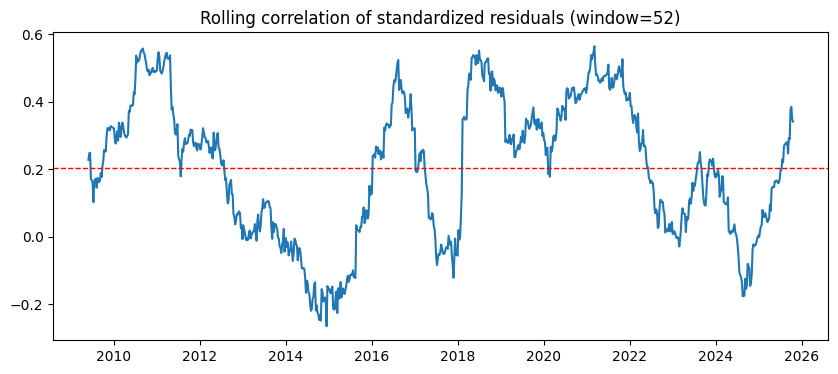

Average rolling correlation: 0.2045


In [7]:
# fit univariate GARCH(1,1) for both (scale by 100)
us_garch = arch_model(data["US_Ret"] * 100, p=1, q=1).fit(disp="off")
cn_garch = arch_model(data["CN_Ret"] * 100, p=1, q=1).fit(disp="off")

us_std = us_garch.resid / us_garch.conditional_volatility
cn_std = cn_garch.resid / cn_garch.conditional_volatility

std = pd.concat([
    data["Date"],
    us_std.rename("US_std"),
    cn_std.rename("CN_std")
], axis=1).dropna()

roll_corr = std["US_std"].rolling(window=52, min_periods=20).corr(std["CN_std"])

plt.figure(figsize=(10, 4))
plt.plot(std["Date"], roll_corr)
plt.title("Rolling correlation of standardized residuals (window=52)")
plt.axhline(roll_corr.mean(), color="red", linestyle="--", linewidth=1)
plt.show()

print(f"Average rolling correlation: {roll_corr.mean():.4f}")

## 6. Time-series ML: linear baseline, XGBoost
We predict **CN_Ret** from its own lags **plus** US lags (the version that worked best).

In [8]:
lags = 4
ml_df = make_lags(data, lags=lags)

cn_feats = [f"CN_lag{i}" for i in range(1, lags + 1)]
us_feats = [f"US_lag{i}" for i in range(1, lags + 1)]
features = cn_feats + us_feats

X = ml_df[features].values
y = ml_df["CN_Ret"].values

print("ML sample size:", X.shape)
print("Features:", features)

tscv = TimeSeriesSplit(n_splits=5)

# 6.1 linear baseline
preds_lin = np.zeros_like(y, dtype=float)
for train_idx, test_idx in tscv.split(X):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])

    lr = LinearRegression()
    lr.fit(X_train, y[train_idx])
    preds_lin[test_idx] = lr.predict(X_test)

print("Lin RMSE:", np.sqrt(mean_squared_error(y, preds_lin)))
print("Lin R2:", r2_score(y, preds_lin))

# 6.2 XGBoost with same splits
preds_xgb = np.zeros_like(y, dtype=float)
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=100,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds_xgb[test_idx] = model.predict(X_test)

print("XGBoost RMSE:", np.sqrt(mean_squared_error(y, preds_xgb)))
print("XGBoost R2:", r2_score(y, preds_xgb))

ML sample size: (871, 8)
Features: ['CN_lag1', 'CN_lag2', 'CN_lag3', 'CN_lag4', 'US_lag1', 'US_lag2', 'US_lag3', 'US_lag4']
Lin RMSE: 0.03378548448661939
Lin R2: -0.02447827648899703
XGBoost RMSE: 0.0361765168594533
XGBoost R2: -0.1746161057059723


## 7. NN template with time-series CV
Note: with weekly returns this will likely **not** beat the linear model — kept here as template.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

preds_nn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in TimeSeriesSplit(n_splits=5).split(X):
    # scale per fold to avoid lookahead
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X[train_idx])
    X_test = scaler.transform(X[test_idx])
    y_train = y[train_idx]
    y_test = y[test_idx]

    nn = Sequential([
        Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
        Dense(16, activation="relu"),
        Dense(1)
    ])
    nn.compile(optimizer="adam", loss="mse")
    es = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)

    nn.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=60,
        verbose=0,
        callbacks=[es]
    )

    preds_nn[test_idx] = nn.predict(X_test, verbose=0).flatten()

print("NN RMSE:", np.sqrt(mean_squared_error(y, preds_nn)))
print("NN R2:", r2_score(y, preds_nn))

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_reg

/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/pd_env/lib/python3.13/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN RMSE: 0.06597916415067567
NN R2: -2.907113886817111


## 8. Enriching features: momentum, volatility, rolling corr
To improve predictability, add state variables.

In [10]:
df = data.copy()
df["US_mom_12"] = df["US_Ret"].rolling(12).sum()
df["CN_mom_12"] = df["CN_Ret"].rolling(12).sum()
df["US_vol_12"] = df["US_Ret"].rolling(12).std()
df["CN_vol_12"] = df["CN_Ret"].rolling(12).std()
df["rollcorr_12"] = df["US_Ret"].rolling(12).corr(df["CN_Ret"])
df = df.dropna().reset_index(drop=True)

ml_df2 = make_lags(df, lags=4)
lag_feats = [c for c in ml_df2.columns if "lag" in c]
extra_feats = ["US_mom_12", "CN_mom_12", "US_vol_12", "CN_vol_12", "rollcorr_12"]
features2 = lag_feats + extra_feats

X2 = ml_df2[features2].values
y2 = ml_df2["CN_Ret"].values

tscv = TimeSeriesSplit(n_splits=5)
preds_xgb2 = np.zeros_like(y2, dtype=float)
for train_idx, test_idx in tscv.split(X2):
    model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=150, random_state=42)
    model.fit(X2[train_idx], y2[train_idx])
    preds_xgb2[test_idx] = model.predict(X2[test_idx])

print("XGB (enriched) RMSE:", np.sqrt(mean_squared_error(y2, preds_xgb2)))
print("XGB (enriched) R2:", r2_score(y2, preds_xgb2))

XGB (enriched) RMSE: 0.034582815222617906
XGB (enriched) R2: -0.10548007719138863
